# Mental Health Text Classification Dataset
Ссылка на оригинальный датасет:
https://www.kaggle.com/datasets/priyangshumukherjee/mental-health-text-classification-dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyangshumukherjee/mental-health-text-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chest\.cache\kagglehub\datasets\priyangshumukherjee\mental-health-text-classification-dataset\versions\2


## EDA

In [2]:
import pandas as pd

train_df = pd.read_csv(path + "\\mental_heath_unbanlanced.csv", )  # опечатки в названии файла, оставил как в оригинале
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49612 entries, 0 to 49611
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  40012 non-null  float64
 1   text       49612 non-null  object 
 2   status     49612 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


Хотелось бы использовать Unique_ID как индекс(просто потому что они есть и вроде как уникальны), но колонка имеет ~9 тысяч пустых значений.
Поскольку для классификации текста его айди не имеет значения дропнем её целиком

In [3]:
train_df = train_df.drop('Unique_ID', axis=1)
train_df.head(5)

,text,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
import seaborn as sns

sns.set_theme(context='notebook',
              palette='Set2')

Посмотрим количество значений каждого класса

<Axes: xlabel='status', ylabel='count'>

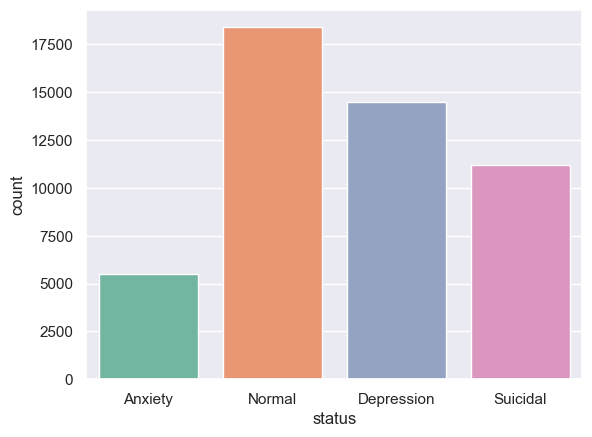

In [5]:
sns.countplot(data=train_df, x='status', hue='status')

Есть ли связь между длиной текста и классом?

In [6]:
train_df.head(5)

,text,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
#считаем длину текста
train_df['text_len'] = train_df['text'].str.len()

<Axes: xlabel='status', ylabel='text_len'>

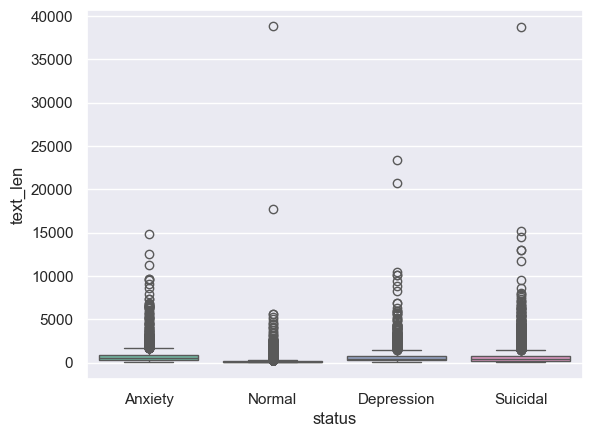

In [8]:
# строим boxplot для анализа распределения
sns.boxplot(data=train_df, x='status', y='text_len', hue='status')

Визуально не похоже, что длина сообщения явно коррелирует с классом. Есть много длинных сообщений(~больше тысячи символов) в каждом классе.
Для дальнейшей работы оставим только текст и классы.

In [9]:
train_df = train_df.drop('text_len', axis=1)

Кодируем классы в метки

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])

## TF-IDF и LogisticRegression

In [11]:
X = train_df['text']
y = train_df['status']

Разделим файл на тренировочную и тестовую выборку, указав параметр stratify=y.

В данных есть отдельный файл для теста, на нем сможем проверить качество.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=2,
        max_features=100_000,
        sublinear_tf=True,
    )),
    ("lr", LogisticRegression(max_iter=1000, class_weight='balanced')),
])

In [14]:
# Обучение
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100000, min_df=2,
                                 sublinear_tf=True)),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [15]:
#Оценка
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     Anxiety       0.74      0.84      0.79      1101
  Depression       0.75      0.62      0.68      2901
      Normal       0.90      0.94      0.92      3678
    Suicidal       0.67      0.73      0.70      2243

    accuracy                           0.79      9923
   macro avg       0.76      0.78      0.77      9923
weighted avg       0.79      0.79      0.78      9923



In [16]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1: ", f1_macro)

Macro F1:  0.7697667609381362


Предсказания логистической регрессии считаем за бейзлайн, далее попробуем предсказания через трансформеры

## transformers

In [17]:
# Так как мы проводили преобразования в pipeline, сам датасет не изменился, можем взять train_df для работы.
train_df.head()

,text,status
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0


In [18]:
# разделение на трейн и тест
# каст в ClassLabel нужен для stratify_by_column
from datasets import Dataset, ClassLabel

dataset = Dataset.from_pandas(
    train_df[['text', 'status']]
)
num_labels = train_df['status'].nunique()
dataset = dataset.cast_column('status', ClassLabel(num_classes=num_labels))

dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='status')

train_ds = dataset['train']
val_ds = dataset['test']

Casting the dataset:   0%|          | 0/49612 [00:00<?, ? examples/s]

In [19]:
train_ds = train_ds.rename_column("status", "labels")
val_ds   = val_ds.rename_column("status", "labels")


In [21]:
# токенизация
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def tokenize(batch):
    return tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=256,
    )


train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

train_ds.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'labels']
)
val_ds.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'labels']
)

Map:   0%|          | 0/39689 [00:00<?, ? examples/s]

Map:   0%|          | 0/9923 [00:00<?, ? examples/s]

In [24]:
# модель
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels,
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [25]:
import torch
from torch.nn import CrossEntropyLoss
from transformers import Trainer

class_counts = train_df['status'].value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.values, dtype=torch.float)

In [26]:
class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None
    ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [27]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "f1_macro": f1_score(labels, preds, average="macro")
    }


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./distilbert_cls',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    fp16=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    logging_steps=100,
    report_to='none'
)


In [29]:
# Если возвращается None лучше переустановить pytorch c cuda, обучение без gpu может занять очень много времени.
print(torch.version.cuda)

11.8


In [30]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.464162,0.440152,0.825806


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.464162,0.440152,0.825806
2,0.370558,0.429289,0.835157


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.464162,0.440152,0.825806
2,0.370558,0.429289,0.835157
3,0.215901,0.438543,0.843451


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.464162,0.440152,0.825806
2,0.370558,0.429289,0.835157
3,0.215901,0.438543,0.843451


There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=7443, training_loss=0.36978544247786266, metrics={'train_runtime': 16058.568, 'train_samples_per_second': 7.415, 'train_steps_per_second': 0.463, 'total_flos': 7886529157957632.0, 'train_loss': 0.36978544247786266, 'epoch': 3.0})

In [31]:
metrics = trainer.evaluate()
print("Macro F1:", metrics['eval_f1_macro'])


Macro F1: 0.8434510393912784


C distilbert получили прирост на ~7%.
Из недостатков - первая модель обучается несколько минут, вторая - несколько часов.

Можно было добавить раннюю остановку(после 2ой эпохи показатели не менялись, разница между 1 и 2 небольшая).
Так же могут быть доступны ресурсы для обучения, которые позволят обучать модель в приемлемые сроки.